In [2]:
%load_ext autoreload
%autoreload 2

In [271]:
import xarray as xr
import torch
from pathlib import Path
from hython.utils import write_to_zarr, build_mask_dataarray
import matplotlib.pyplot as plt
from pathlib import Path
from hython.datasets.datasets import get_dataset
from numcodecs import Blosc

from torch.utils.data import Dataset, DataLoader

In [272]:
from hython.trainer import XBatcherTrainer
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer

import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

In [273]:
#from torchvision.datasets import MovingMNIST

In [274]:
dir_surr_input = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")


static = xr.open_dataset(dir_surr_input / "staticmaps.nc")#.chunk("auto")
dynamic = xr.open_dataset(dir_surr_input/ "forcings.nc")#.chunk("auto") # C T W H => N T C H W
target = xr.open_dataset(dir_surr_input / "run_default/output.nc").sel(layer=1).isel(lat=slice(None, None, -1))#.chunk("auto") # C T W H => N T C H W


surr_model_output = "convlstm.pt"
experiment = "exp1" # experiment name

dir_surr_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"

SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

mask_from_static = ["wflow_lakeareas"]
rename_mask = ["mask_lake"]


dataset = "XBatchDataset"


# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
KERNEL_SIZE = (3, 3)
NUM_LSTM_LAYER = 2
OUTPUT_SIZE = len(target_names)


TARGET_WEIGHTS = {t:0.5 for t in target_names}



# train/test parameters
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

EPOCHS = 90
BATCH = 64
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 360


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])


In [275]:
wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")

In [276]:
try:
    dynamic = dynamic.rename({"latitude":"lat", "longitude":"lon"})
    static = static.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

In [292]:
# masking 

mask_missing = np.isnan(static[static_names[0]]).rename("mask_missing")

masks = []
masks.append(mask_missing)

for i, mask in enumerate(mask_from_static):
    masks.append((static[mask] > 0).astype(np.bool_).rename(rename_mask[i]))

masks = build_mask_dataarray(masks, names = ["mask_missing"]+ rename_mask).any(dim="mask_layer")

In [70]:
# filter 
dynamic = dynamic[dynamic_names]
target = target[target_names]
static = static.drop_dims("time").sel(layer=1)[ static_names ] 

In [72]:
# expand static to dynamic 
time_da = xr.DataArray(dynamic.time.values, [('time', dynamic.time.values)])
static = static.expand_dims({"time":time_da})

In [11]:
dynamic = dynamic.to_array() # C T H W
static = static.to_array() # C T H W
target = target.to_array() # C T H W

In [73]:
dynamic_train = dynamic.sel(time=train_temporal_range)
static_train = static.sel(time=train_temporal_range)
target_train = target.sel(time=train_temporal_range)

dynamic_test = dynamic.sel(time=test_temporal_range)
static_test = static.sel(time=test_temporal_range)
target_test = target.sel(time=test_temporal_range)

In [13]:
target_train.shape, static_train.shape, dynamic_train.shape, masks.shape

((2, 1096, 180, 223), (6, 1096, 180, 223), (3, 1096, 180, 223), (180, 223))

In [133]:
# normalize

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", shape="2D")

normalizer_static = Normalizer(method="standardize", type="space", shape="2D")

normalizer_target = Normalizer(method="standardize", type="spacetime", shape="2D")

normalizer_dynamic.compute_stats(dynamic_train)
normalizer_static.compute_stats(static_train)
normalizer_target.compute_stats(target_train)

# TODO: save stats, implement caching of stats to save computation

dynamic = normalizer_dynamic.normalize(dynamic_train)
static = normalizer_static.normalize(static_train)
target = normalizer_target.normalize(target_train)

dynamic_test = normalizer_dynamic.normalize(dynamic_test)
static_test = normalizer_static.normalize(static_test)
target_test = normalizer_target.normalize(target_test)

compute stats
compute stats
compute stats


In [134]:
# masking 
dynamic_train = dynamic_train.where(~masks, 0)

static_train = static_train.where(~masks, 0)

target_train = target_train.where(~masks, 0)


dynamic_test = dynamic_test.where(~masks, 0)

static_test = static_test.where(~masks, 0)

target_test = target_test.where(~masks, 0)

In [166]:
# compressor = Blosc(cname='zl4', clevel=9, shuffle=Blosc.BITSHUFFLE)

# ss = params.drop_dims("time")[[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"]].expand_dims({"time": ds.time}).chunk({"time":500, "latitude":50, "longitude":50})

# ss.to_zarr(wd / "test.zarr",storage_options={"compressor":compressor})

# ss = xr.open_dataset( wd / "test.zarr", engine = "zarr")

# time, lat, lon = 365, 16, 16 

In [14]:
import xbatcher

In [122]:
xbatcher.BatchGenerator?

Init signature:
xbatcher.BatchGenerator(
    ds: Union[xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray],
    input_dims: Dict[Hashable, int],
    input_overlap: Dict[Hashable, int] = {},
    batch_dims: Dict[Hashable, int] = {},
    concat_input_dims: bool = False,
    preload_batch: bool = True,
)
Docstring:     
Create generator for iterating through Xarray DataArrays / Datasets in
batches.

Parameters
----------
ds : ``xarray.Dataset`` or ``xarray.DataArray``
    The data to iterate over
input_dims : dict
    A dictionary specifying the size of the inputs in each dimension,
    e.g. ``{'lat': 30, 'lon': 30}``
    These are the dimensions the ML library will see. All other dimensions
    will be stacked into one dimension called ``sample``.
input_overlap : dict, optional
    A dictionary specifying the overlap along each dimension
    e.g. ``{'lat': 3, 'lon': 3}``
batch_dims : dict, optional
    A dictionary specifying the size of the batch along each dimension
    e.g. 

## Test xbatcher

Check whether I can get and index of the chunks so that I can do:

$$ \mathbf{f}: \mathbb{R}^1 \rightarrow \mathbb{R}^2$$

f(0) => (0,0) </br>
f(1) => (0,1) </br>
f(2) => (1,0) </br>
f(3) => (1,1) </br>

In [ ]:
xgen = xbatcher.BatchGenerator(
    dynamic_train,
    input_dims={"lat":80, "lon":80, "time":360}, # dimension size of the sample cube
    preload_batch=True,
    #batch_dims={"time":60, "lat":80, "lon":80},
    #concat_input_dims= True,
    #input_overlap={"time":10, "lat":10, "lon":10} # overlaps between dimensions of each cube
)

In [245]:
len(xgen)

12

In [246]:
sample = xgen[11]

In [248]:
ds = xr.merge(xgen)

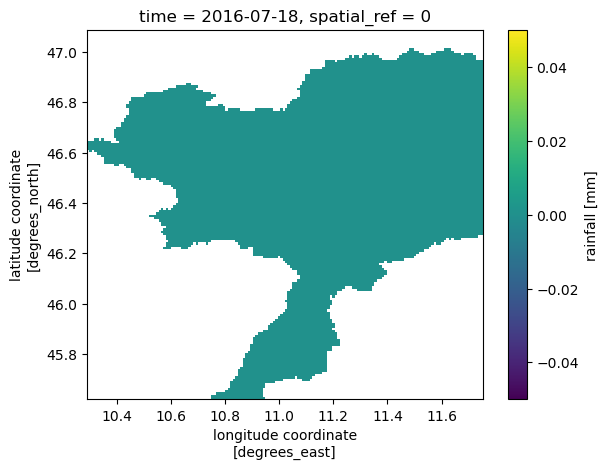

In [250]:
ds.isel(time=199).precip.plot()

In [221]:
# this should work for the convLSTM 
sample_convlstm = sample.to_stacked_array(new_dim="feat", sample_dims=("lat","lon", "time"))

In [ ]:
sample_convlstm.shape

In [230]:
# how to handle null cubes
sample_convlstm.isnull().all().item(0)

True

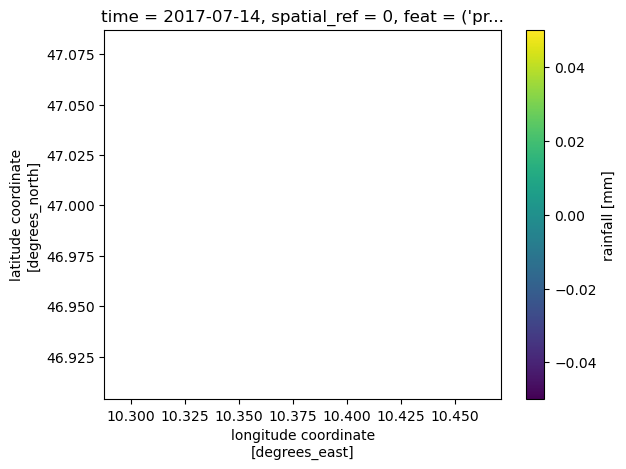

In [223]:
#sample_convlstm.sel(feat="precip").isel(time=10).plot()

In [210]:
# this should work for the 1D lstm
sample_lstm = sample_convlstm.stack(gridcell=["lat","lon"])

In [ ]:
#ds.sel(variable="precip").to_dataset(name="ds").to_stacked_array(new_dim="batch", sample_dims=("lon","lat"))

## Example xbatcher from https://github.com/earth-mover/dataloader-demo/blob/main/main.py

In [56]:
def print_json(obj):
    print(json.dumps(obj))
from torch.utils.data import Dataset as TorchDataset
import multiprocessing
class XBatcherPyTorchDataset(TorchDataset):
    def __init__(self, batch_generator: xbatcher.BatchGenerator):
        self.bgen = batch_generator

    def __len__(self):
        return len(self.bgen)

    def __getitem__(self, idx):
        t0 = time.time()
        print_json(
            {
                "event": "get-batch start",
                "time": t0,
                "idx": idx,
                "pid": multiprocessing.current_process().pid,
            }
        )
        # load before stacking
        batch = self.bgen[idx].load()

        print(batch)

        # Use to_stacked_array to stack without broadcasting,
        stacked = batch.to_stacked_array(
            new_dim="batch", sample_dims=("time", "longitude", "latitude")
        ).transpose("time", "batch", ...)
        print(stacked)
        x = torch.tensor(stacked.data)
        t1 = time.time()
        print_json(
            {
                "event": "get-batch end",
                "time": t1,
                "idx": idx,
                "pid": multiprocessing.current_process().pid,
                "duration": t1 - t0,
            }
        )
        return x

In [57]:
import time, json
def setup(source="gcs", patch_size: int = 48, input_steps: int = 3):
    if source == "gcs":
        ds = xr.open_dataset(
            "gs://weatherbench2/datasets/era5/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr",
            engine="zarr",
            chunks={},
        )
    elif source == "arraylake":
        config.set({"s3.endpoint_url": "https://storage.googleapis.com", "s3.anon": True})
        ds = (
            Client()
            .get_repo("earthmover-public/weatherbench2")
            .to_xarray(
                group="datasets/era5/1959-2022-6h-128x64_equiangular_with_poles_conservative",
                chunks={},
            )
        )
    else:
        raise ValueError(f"Unknown source {source}")

    DEFAULT_VARS = [
        "10m_wind_speed",
        "2m_temperature",
        "specific_humidity",
    ]

    ds = ds[DEFAULT_VARS]
    patch = dict(
        latitude=patch_size,
        longitude=patch_size,
        time=input_steps,
    )
    overlap = dict(latitude=32, longitude=32, time=input_steps // 3 * 2)

    bgen = xbatcher.BatchGenerator(
        ds,
        input_dims=patch,
        input_overlap=overlap,
        preload_batch=False,
    )

    dataset = XBatcherPyTorchDataset(bgen)

    return dataset

In [58]:
xgen = setup()

In [59]:
len(xgen)

1104456

In [ ]:
ds = xgen[1]

In [113]:
res = res[1]
res.shape, res.dims, res.coords, len(xgen)

((1096, 20, 20),
 ('time', 'lat', 'lon'),
 Coordinates:
   * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-12-31
   * lon          (lon) float64 10.29 10.3 10.31 10.32 ... 10.45 10.46 10.47
   * lat          (lat) float64 47.08 47.07 47.06 47.05 ... 46.93 46.92 46.91
     spatial_ref  int64 0
     variable     <U3 'pet',
 99)

In [219]:
# for i, b in enumerate(xgen):
#     print(i)
#     print(b.shape)
#     plt.figure()
#     try:
#         b.isel(variable_input=1, sample=0).plot()
#         b.isel(variable_input=1, lat_input=100, lon_input=100).plot(x="time")
#     except Exception as e:
#         print(e)
#         b.isel(variable=1, time=1).plot()
#         b.isel(variable=1, lat=10, lon=10).plot()
#     if i > 20:
#         break

## Test custom "xbatcher"

The current implementation of xbatcher looks cool but it lacks:
- way to index tiles and sequence, it only indexes cubes, therefore how I can subsample only in one of the two dimensions?
- as I don't know the ordering of the cube samples, how can I subsample?
- how to handle NULL cubes
- It drops the "edges" of the dimension (i.e. it does not provide a collate function and cut short returning sample of the same dimension size)

In [288]:
from hython.sampler import compute_grid_indices
import itertools

In [289]:
# Indexing cubelets

In [728]:
data = dynamic.precip.transpose("lat", "lon", "time") # x, y, t

data.shape

(180, 223, 4748)

In [862]:
xsize, ysize, tsize = 20, 20, 4748 # cubelet dimension size
xover, yover, tover= 0, 0, 0 # cubelets overlaps


space_idx = compute_grid_indices(grid=data)

print(space_idx.shape)

(180, 223)


In [863]:
# create cubelets, keep or not edge cubelets
keep_edge_cubelets = True

space_indices = []
space_indices_all_missing = []
space_slices = []
idx = 0
for ix,iy in zip(range(0, data.shape[0], xsize - xover), range(0, data.shape[1], ysize - yover)):
    xslice = slice(ix, ix + xsize)
    yslice = slice(iy, iy + ysize)
    cubelet = space_idx[xslice, yslice]
    mask_cubelet = masks[xslice, yslice]
    
    #plt.figure(figsize=(2,2))
    #plt.imshow(cubelet)
    #plt.annotate(idx, list(map(lambda x: int(x/4), cubelet.shape)) ,color="red", size=20)
    #plt.colorbar()
    space_slices.append([xslice, yslice])
    space_indices.append(idx)
    if mask_cubelet.all().item(0):
        space_indices_all_missing.append(idx)
    idx += 1

In [864]:
# create cubelets, keep or not edge cubelets
keep_edge_cubelets = False

space_indices = []
space_indices_all_missing = []
space_slices = []
idx = 0
for ix in range(0, data.shape[1], ysize - yover):
    for iy in range(0, data.shape[0], xsize - xover):
        xslice = slice(ix, ix + xsize)
        yslice = slice(iy, iy + ysize)
        cubelet = space_idx[xslice, yslice]
        if not keep_edge_cubelets:
            if cubelet.shape != (ysize, xsize):
                continue
        print(cubelet.shape)
        mask_cubelet = masks[xslice, yslice]
        
        #plt.figure(figsize=(2,2))
        #plt.imshow(cubelet)
        #plt.annotate(idx, list(map(lambda x: int(x/4), cubelet.shape)) ,color="red", size=20)
        #plt.colorbar()
        space_slices.append([xslice, yslice])
        space_indices.append(idx)
        if mask_cubelet.all().item(0):
            space_indices_all_missing.append(idx)
        idx += 1

(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)
(20, 20)


In [865]:
time_indices = []
time_slices = []
idx = 0
for it in range(0, data.shape[2], tsize - tover):
    tslice = slice(it, it + tsize)
    cubelet = data[...,tslice]
    time_indices.append(idx)
    time_slices.append(tslice)
    idx += 1

In [866]:
time_indices

[0]

In [867]:
# cubelets idx
cube_idx = list(itertools.product(*(space_indices, time_indices)))

In [868]:
cube_idx[:10]

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0)]

In [869]:
# slices
slice_idx = list(itertools.product(*(space_slices, time_slices)))

In [870]:
len(slice_idx)

81

In [871]:
slice_idx[:10]

[([slice(0, 20, None), slice(0, 20, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(20, 40, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(40, 60, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(60, 80, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(80, 100, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(100, 120, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(120, 140, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(140, 160, None)], slice(0, 4748, None)),
 ([slice(0, 20, None), slice(160, 180, None)], slice(0, 4748, None)),
 ([slice(20, 40, None), slice(0, 20, None)], slice(0, 4748, None))]

In [872]:
# create mapping
mapping_cubelets_slices = {}
for ic, islice in zip(cube_idx, slice_idx):
    sp_slice, t_slice = islice
    tot_slice = (sp_slice[0], sp_slice[1], t_slice)
    print(tot_slice)
    mapping_cubelets_slices[ic] = (sp_slice[0], sp_slice[1], t_slice)
    

(slice(0, 20, None), slice(0, 20, None), slice(0, 4748, None))
(slice(0, 20, None), slice(20, 40, None), slice(0, 4748, None))
(slice(0, 20, None), slice(40, 60, None), slice(0, 4748, None))
(slice(0, 20, None), slice(60, 80, None), slice(0, 4748, None))
(slice(0, 20, None), slice(80, 100, None), slice(0, 4748, None))
(slice(0, 20, None), slice(100, 120, None), slice(0, 4748, None))
(slice(0, 20, None), slice(120, 140, None), slice(0, 4748, None))
(slice(0, 20, None), slice(140, 160, None), slice(0, 4748, None))
(slice(0, 20, None), slice(160, 180, None), slice(0, 4748, None))
(slice(20, 40, None), slice(0, 20, None), slice(0, 4748, None))
(slice(20, 40, None), slice(20, 40, None), slice(0, 4748, None))
(slice(20, 40, None), slice(40, 60, None), slice(0, 4748, None))
(slice(20, 40, None), slice(60, 80, None), slice(0, 4748, None))
(slice(20, 40, None), slice(80, 100, None), slice(0, 4748, None))
(slice(20, 40, None), slice(100, 120, None), slice(0, 4748, None))
(slice(20, 40, None), sl

In [873]:
# function that maps the cubelet indices to the grid indices for chunking

def return_cubelet_slices(cubelet_idx):
    return mapping_cubelets_slices[cubelet_idx]

def return_cubelet_data(data,cubelet_idx):
    return data[*mapping_cubelets_slices[cubelet_idx]]

In [874]:
return_cubelet_data(data, (1,0)).shape

(20, 20, 4748)

In [875]:
# missing values
def cubelet_idx_with_all_missing_values(mapping_cubelets, cubelets_idx_missing, time_indices):

    new_map = mapping_cubelets.copy()
    for t in time_indices:
        for idx in cubelets_idx_missing:
            try:
                new_map.pop((idx,t)) 
            except:
                pass
    return new_map

# can create 

In [876]:
new_mapping = cubelet_idx_with_all_missing_values(mapping_cubelets_slices, space_indices_all_missing, time_indices)

In [877]:
[new_mapping[(1,0)]] # lat, lon, time

KeyError: (1, 0)

In [878]:
temp = dynamic.precip.transpose("lat", "lon", "time")

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/xarray/plot/utils.py:457: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kws)


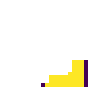

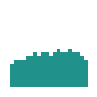

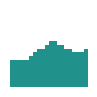

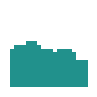

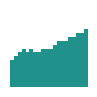

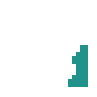

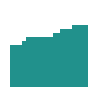

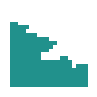

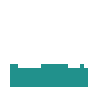

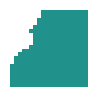

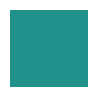

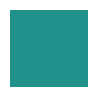

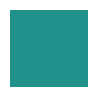

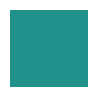

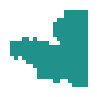

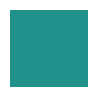

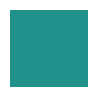

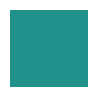

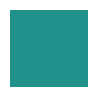

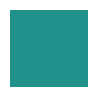

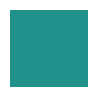

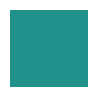

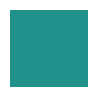

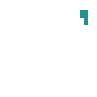

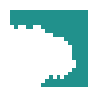

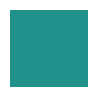

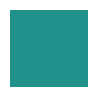

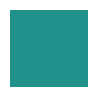

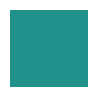

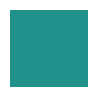

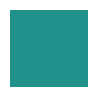

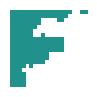

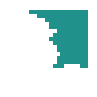

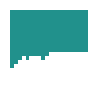

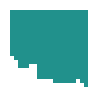

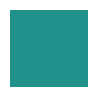

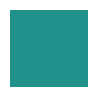

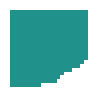

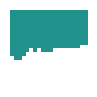

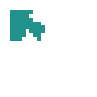

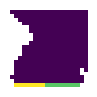

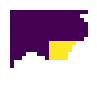

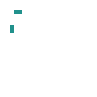

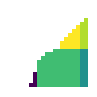

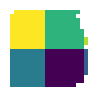

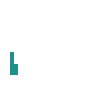

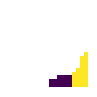

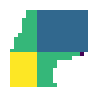

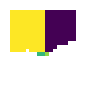

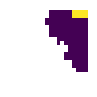

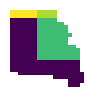

In [879]:
for k in new_mapping:
    temp[new_mapping[k]].isel(time=1).plot(figsize=(1,1), add_colorbar=False)
    plt.axis('off')
    plt.title("")

In [880]:
# torch dataset
# collate function to make cubelets of the same shape! and do padding with zeros!

In [881]:
class CubeletsDataset(Dataset):

    def __init__(self, xd, cubelet_indices):
        self.xd = xd
        self.cubelet_indices = cubelet_indices

    def __len__(self):
        return len(self.cubelet_indices)

    def __getitem__(self, index):

        cubelet_idx = list(self.cubelet_indices.keys())[index]
        print(cubelet_idx, self.cubelet_indices[cubelet_idx])
        out = self.xd[*self.cubelet_indices[cubelet_idx]].values
        return torch.tensor(out)

In [882]:
dataset = CubeletsDataset(data, new_mapping)

In [883]:
# sampler 
from hython.sampler import SubsetRandomSampler, SubsetSequentialSampler

In [884]:
sampler = SubsetRandomSampler(range(len(new_mapping.keys())))

In [885]:
sampler = SubsetSequentialSampler(range(len(new_mapping.keys())))

In [886]:
dataloader = DataLoader(dataset = dataset , batch_size = 2, sampler=sampler)

In [887]:
len(dataloader)

26

In [888]:
next(iter(dataloader)).shape

(4, 0) (slice(0, 20, None), slice(80, 100, None), slice(0, 4748, None))
(5, 0) (slice(0, 20, None), slice(100, 120, None), slice(0, 4748, None))


torch.Size([2, 20, 20, 4748])

(4, 0) (slice(0, 20, None), slice(80, 100, None), slice(0, 4748, None))
(5, 0) (slice(0, 20, None), slice(100, 120, None), slice(0, 4748, None))
torch.Size([2, 20, 20, 4748])
(6, 0) (slice(0, 20, None), slice(120, 140, None), slice(0, 4748, None))
(7, 0) (slice(0, 20, None), slice(140, 160, None), slice(0, 4748, None))
torch.Size([2, 20, 20, 4748])
(8, 0) (slice(0, 20, None), slice(160, 180, None), slice(0, 4748, None))
(9, 0) (slice(20, 40, None), slice(0, 20, None), slice(0, 4748, None))
torch.Size([2, 20, 20, 4748])
(10, 0) (slice(20, 40, None), slice(20, 40, None), slice(0, 4748, None))
(11, 0) (slice(20, 40, None), slice(40, 60, None), slice(0, 4748, None))
torch.Size([2, 20, 20, 4748])
(12, 0) (slice(20, 40, None), slice(60, 80, None), slice(0, 4748, None))
(13, 0) (slice(20, 40, None), slice(80, 100, None), slice(0, 4748, None))
torch.Size([2, 20, 20, 4748])
(14, 0) (slice(20, 40, None), slice(100, 120, None), slice(0, 4748, None))
(15, 0) (slice(20, 40, None), slice(120, 140, N

/tmp/ipykernel_444821/2785654874.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2,2))


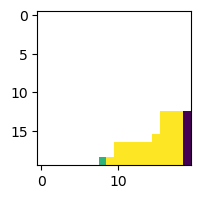

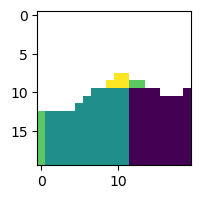

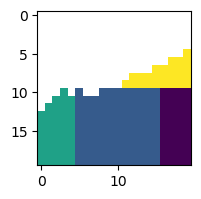

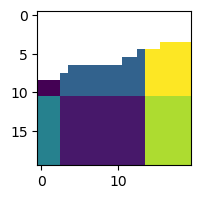

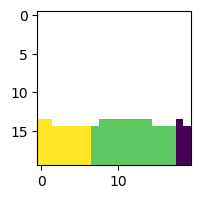

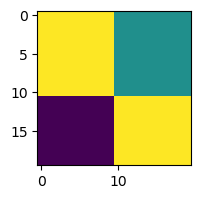

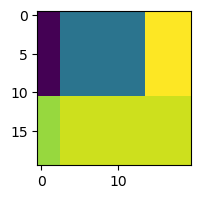

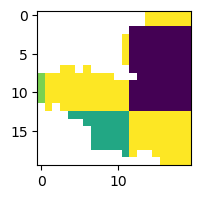

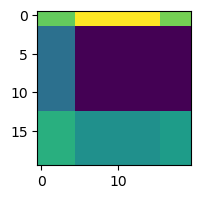

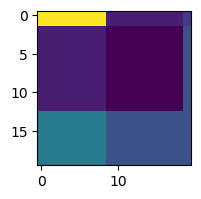

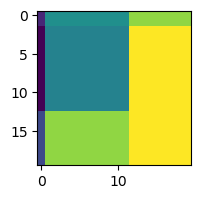

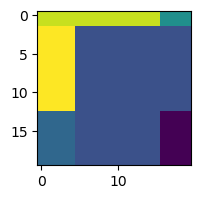

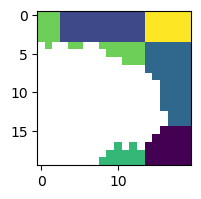

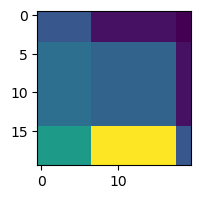

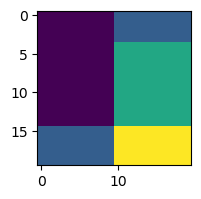

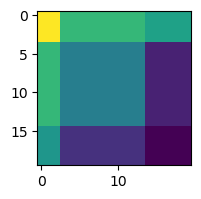

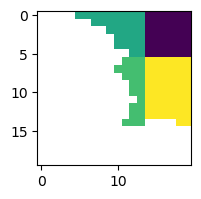

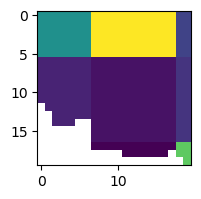

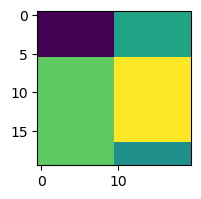

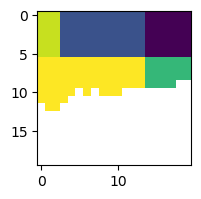

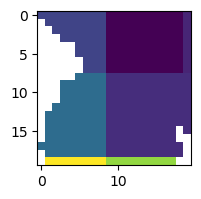

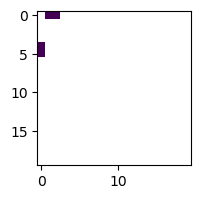

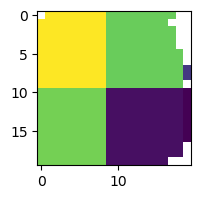

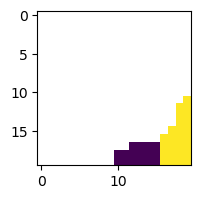

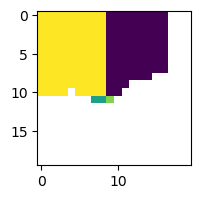

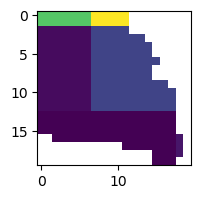

In [889]:
for i in dataloader:
    print(i.shape)
    plt.figure(figsize=(2,2))
    plt.imshow(i[0 , :, : , 0])

In [ ]:
time, lat ,lon = 360, 32,32

In [ ]:
train_dataset = get_dataset("XBatchDataset")(
                      dynamic_train, 
                      target_train, 
                      static_train, 
                      lstm=False, 
                      xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
                                       "batch_dims": {"lat":lat, "lon":lon}, 
                                       #"input_overlap":{"time":1},
                                       "concat_input_dims":False,
                                       "preload_batch":True})
test_dataset = get_dataset("XBatchDataset")(
                      dynamic_test, 
                      target_test, 
                      static_test, 
                      lstm=False, 
                      xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
                                       "batch_dims": {"lat":lat, "lon":lon}, 
                                       #"input_overlap":{"time":1},
                                       "concat_input_dims":False,
                                       "preload_batch":True})

In [154]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16)

In [155]:
len(train_dataloader), len(test_dataloader)

(6, 4)

In [156]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape, next(iter(train_dataloader))[2].shape

(torch.Size([16, 360, 3, 32, 32]),
 torch.Size([16, 360, 6, 32, 32]),
 torch.Size([16, 360, 2, 32, 32]))

In [157]:
from hython.models.convLSTM import ConvLSTM

In [158]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [159]:
model = ConvLSTM(
    input_dim =  DYNAMIC_INPUT_SIZE + STATIC_INPUT_SIZE,
    output_dim= OUTPUT_SIZE,
    hidden_dim = (HIDDEN_SIZE),
    kernel_size = KERNEL_SIZE,
    num_layers = NUM_LSTM_LAYER,
    batch_first = True,
    bias = True,
    return_all_layers = False
).to(device)

In [160]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight={"vwc":0.5, "actevap":0.5})
metric_fn = MSEMetric(target_names=["vwc", "actevap"])

In [161]:
trainer = XBatcherTrainer(
    RNNTrainParams(
               experiment=experiment, 
               temporal_subsampling=False, 
               temporal_subset=1, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [162]:
file_surr_output = f"{dir_surr_output}/{experiment}_{surr_model_output}"

In [ ]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_dataloader,
    test_dataloader,
    10,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
)

  0%|                                                                                                         | 0/10 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt"))

In [49]:
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(33, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

In [ ]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('SM')
axs[0].set_ylabel(metric_fn.__class__.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
axs[1].set_title('ET')
axs[1].set_ylabel(metric_fn.__class__.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[2].set_title('Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [50]:
def predict(Xd, Xs, model, batch_size, device):
    model = model.to(device)
    X = torch.concat([Xd, Xs], 2).to(device)
    arr = []
    for i in range(0, Xd.shape[0], batch_size):
        out = model(X)[0]
        #import pdb;pdb.set_trace()
        arr.append(out[i : (i + batch_size)].detach().cpu().numpy())
    return np.vstack(arr)

In [51]:
output = predict(res[0], res[1], model, batch_size=8,device=device)

In [52]:
import matplotlib.pyplot as plt

In [53]:
output.shape

(16, 360, 32, 32, 2)

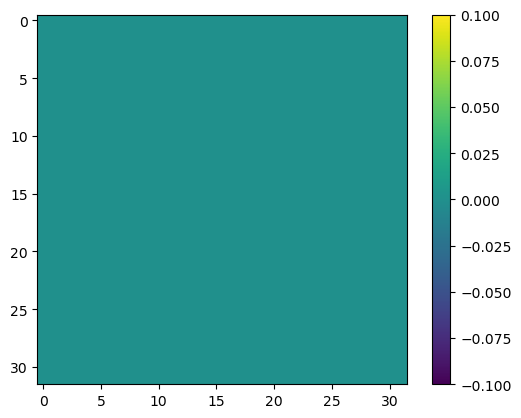

In [61]:
plt.imshow(output[10,-1,:,:,0])
plt.colorbar()

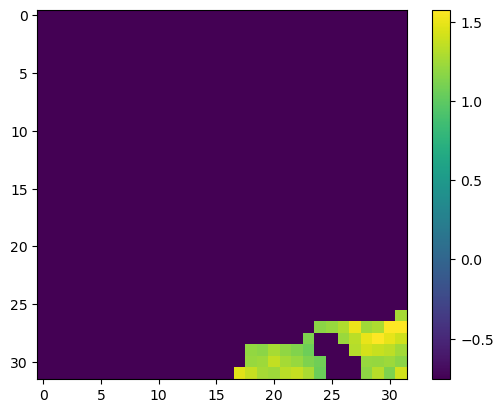

In [55]:
plt.imshow(res[2][0,-1,0,:,:])
plt.colorbar()

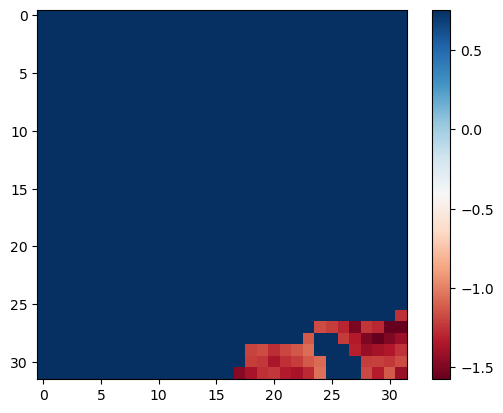

In [56]:
plt.imshow((output[0,-1,:,:,0] - np.array(res[2][0,-1,0,:,:])), cmap="RdBu")
plt.colorbar()

In [ ]:
torch

In [ ]:
torch.split?